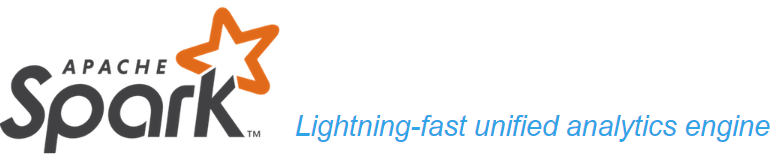



*Note: Apache Spark is trade mark of Apache Software Foundation*

# RDD Operations

There are two types of operations on RDDs:

 - Transformations
 - Actions
 
The first type of operation is called a transformation. You can create new RDDs from existing RDDs by applying what are called transformations. For example, to get an RDD containing only the lines containing the word ‘error’, you can apply a filter transformation to the original RDD. 


Some examples of transformations are:
- map - runs a function over each element of an RDD
- flatMap - runs a function where the output of each element may not be a single element
- groupByKey - data is grouped according to a key value
- union - takes the set union of two RDDs

In case an RDD is lost during computation, Spark can recreate it using its transformation history (lineage). For example, in the above diagram, if RDD 3 is lost due to a power failure or a memory error, Spark will refer to the lineage chart, and recover RDD 3 by applying a transformation on RDD 2.

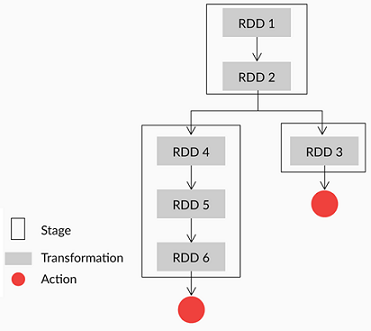

Thus, the lineage enables Spark to achieve fault-tolerance. This is precisely why they are termed resilient datasets. Note that the lineage stores details of the transformations, not the data itself. Once the transformations leading up to an RDD are known, any stage (representing a subset of the original data) can be recreated.

The second type of operation is called an action. An action usually involves operations like counting or saving to disk. Actions trigger all the transformations behind it.

Some examples of actions are:
- count - counts the number of elements in the RDD
- collect - persists the RDD to a local machine
- reduce - reduces the elements through an aggregation function. The most common type of reduce function is a sum

The main difference between transformations and actions is that actions return a value or export data to a system, whereas transformations always return new RDDs. Also, transformations are not evaluated until an action is called (they just sit there, waiting to be executed). This property of Spark optimizes its computation, and is called ‘Lazy Evaluation’. Due to this property, Spark does not perform unnecessary computation. More specifically, it performs computation only when a final result is required.


Let's try to run some transformations and actions now.

### Loading SparkConf and SparkContext

In [ ]:
# loading SparkContext and SparkConf from the library pyspark
# Setting the application name and cluster mode using SparkConf

from pyspark import SparkConf,SparkContext
conf = SparkConf().setMaster("YARN").setAppName("RDD Operations")
sc = SparkContext().getOrCreate(conf=conf)

### Creating RDD from a file

In [ ]:
# reading a text file into an RDD
# transformation

rdd = sc.textFile("/common_folder/pyspark_data/blogtext/blogtexts.txt")

In [ ]:
# collect: loads the complete data in the driver program
# action

rdd.collect()

In [ ]:
# take: returns fixed numner of elements of he RDD
# action

rdd.take(5)

### Convert all words in a RDD to lowercase and splitting the lines of a document using space

In [ ]:
# defining a function (same as python)

def lowerSplit(lines):
      lines = lines.lower()
      lines = lines.split()
      return lines

In [ ]:
# map:implementing the function on each element in the RDD

rdd_1 = rdd.map(lowerSplit)

In [ ]:
# action

rdd_1.take(5)

In [ ]:
# flatMap: implements a function on each element where the output of each element may not be a single element
# better than map if you want the each element separately 

rdd_2 = rdd.flatMap(lowerSplit)

In [ ]:
# action

rdd_2.take(5)

### Removing the unnecessary words to analyze the text. We call these words as “stop words"

In [ ]:
# removing a list of frequent appearing words from the rdd
# filter: filters the elements in the RDD based in the condition provided
# filter is a transformation

stopwords = ['is','am','are','the','for','a']
rdd_3 = rdd_2.filter(lambda x: x not in stopwords)
rdd_3.take(10)

### Grouping the words in above RDD, based on the starting letters

In [ ]:
# We have to pass a function inside the “groupBy” which will take the first 3 characters of each word in “rdd_3”.
# The key is the first 3 characters and value is all the words which start with these 3 characters

rdd_4 = rdd_3.groupBy(lambda w: w[0:3])
print([(k, list(v)) for (k, v) in rdd_4.take(2)])

### Counting occurence of each word in corpus

In [ ]:
# aggregating the count of similar words together

rdd_3_mapped = rdd_3.map(lambda x: (x,1))
rdd_3_grouped = rdd_3_mapped.groupByKey()

# ('key', [value1, value2, ...])

In [ ]:
# grouping all the occurences as 1

print(list((j[0], list(j[1])) for j in rdd_3_grouped.take(5)))

In [ ]:
# aggregating occurences of each word and sorting it based on the count

rdd_3_freq_of_words = rdd_3_grouped.mapValues(sum).map(lambda x: (x[1],x[0])).sortByKey()

In [ ]:
# action

rdd_3_freq_of_words.take(10)

In [ ]:
# aggregating occurences of each word using reduceby (instead of groupby) and sorting it in descending order based on the count

rdd_3_mapped.reduceByKey(lambda x,y: x+y).map(lambda x:(x[1],x[0])).sortByKey(False).take(10)

### Counting the words ‘spark’ and ‘apache’ in rdd_3 on each partition separately

In [ ]:
# counting the words in each partition separately

def func(iterator):
    count_spark = 0
    count_apache = 0
    for i in iterator:
        if i =='spark':
            count_spark = count_spark + 1
        if i == 'apache':
            count_apache = count_apache + 1
    return (count_spark,count_apache)

In [ ]:
# mapPartitions: mapping the defined function on each partiotion individually
# glom(): returns an RDD created by coalescing all elements within each partition into a list

rdd_3.mapPartitions(func).glom().collect()

### Working with samples instead of full data 

In [ ]:
# generating samples from the data

rdd_3_sampled = rdd_3.sample(False, 0.4, 42)
print(len(rdd_3.collect()),len(rdd_3_sampled.collect()))

### Union of two RDDs

In [ ]:
# taking union of two datasets

sample_1 = rdd_3.sample(False,0.2,42)
sample_2 =rdd_3.sample(False,0.2,42)
union_of_sample1_sample2 = sample_1.union(sample_2)
print(len(sample_1.collect()), len(sample_2.collect()),len(union_of_sample1_sample2.collect()))

### Joining the paired RDDs based on their key

In [ ]:
# joiing two RDDs based on the key

sample_1 = rdd_3_mapped.sample(False,.2,42)
sample_2 = rdd_3_mapped.sample(False,.2,42)
join_on_sample1_sample2 = sample_1.join(sample_2)
join_on_sample1_sample2.take(20)

### Fetching distinct elements in a RDD

In [ ]:
# distict elements

rdd_3_distinct = rdd_3.distinct()
len(rdd_3_distinct.collect())

### Reducing the number of partitions of a RDD

In [ ]:
# getting the number of partitions in the rdd

rdd_3.getNumPartitions()

In [ ]:
# reducing the number of partitions in the rdd

rdd_3_coalesce = rdd_3.coalesce(3)

In [ ]:
# reducing the number of partitions in the rdd using repartition
# repartition can be used to increase the partitions as well

rdd_3_coalesce=rdd_3.repartition(4)

In [ ]:
# getting the number of partitions in the rdd

rdd_3_coalesce.getNumPartitions()

### Adding numbers in a RDD

In [ ]:
# using range command to create rdd with parallelize 

num_rdd = sc.parallelize(range(1,1000))
num_rdd.reduce(lambda x,y: x+y)

### Counting the number of elements in RDD

In [ ]:
# count of elements in RDD

rdd_3.count()

### Max, Min, Sum, Variance and Stdev over the RDD

In [ ]:
# actions: mathematical operations performed over the RDD

num_rdd.max(),num_rdd.min(), num_rdd.sum(),num_rdd.variance(),num_rdd.stdev()